In [33]:

import sys
import numpy as np
import tensorflow.keras.backend as K

from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, LSTM, Lambda,Add,Embedding,Reshape
from tensorflow.keras.regularizers import l2
from collections import deque
import random

In [34]:
class D3QNAgent:
    """ Agent Class (Network) for DDQN
    """

    def __init__(self, state_dim, action_dim,gamma=0.95,epsilon=1.0,epsilon_min=0.01
                ,epsilon_decay=0.9999, batch_size=32,ddqn=True,Soft_Update=False,dueling=True):
        self.state_dim = state_dim
        self.action_dim = action_dim

        
        self.EPISODES = 2000
        self.memory = deque(maxlen=10000)
        
        self.gamma = gamma    # discount rate
        self.epsilon = epsilon  # exploration rate
        self.epsilon_min = epsilon_min # minimum exploration probability
        self.epsilon_decay = epsilon_decay # exponential decay rate for exploration prob
        self.batch_size = batch_size 
        self.train_start = 1000

        # defining model parameters
        self.ddqn = ddqn # use doudle deep q network
        self.Soft_Update = Soft_Update # use soft parameter update
        self.dueling = dueling # use dealing netowrk

        self.TAU = 0.1 # target network soft update hyperparameter
        
        # Initialize Deep Q-Network
        t = (self.state_dim,)
        self.model = self.network(t,self.action_dim,self.dueling)
        # Build target Q-Network
        self.target_model = self.network(t,self.action_dim,self.dueling)
        self.target_model.set_weights(self.model.get_weights())

    def huber_loss(self, y_true, y_pred):
        return K.mean(K.sqrt(1 + K.square(y_pred - y_true)) - 1, axis=-1)

    def network(self, input_shape, action_space, dueling):
        """ Build Deep Q-Network
        """
        X_input = Input(shape=input_shape)
        X = Embedding(500, 10, input_length=1)(X_input)
        X = Flatten()(X)
        X = Dense(50, activation="relu", kernel_initializer='he_uniform')(X)
        X = Dense(50, activation="relu", kernel_initializer='he_uniform')(X)
#         X = Dense(64, activation="relu", kernel_initializer='he_uniform')(X)

        if dueling:
            state_value = Dense(1, kernel_initializer='he_uniform')(X)
            #Q = V + A - mean(A)
            #V = s[:, 0]
            state_value = Lambda(lambda s: K.expand_dims(s[:, 0], -1), output_shape=(action_space,))(state_value)

            action_advantage = Dense(action_space, kernel_initializer='he_uniform')(X)
            #Q = V + A - mean(A)
            #A = a[:, :]
            # mean(A) = K.mean(a[:, :], keepdims=True)
            action_advantage = Lambda(lambda a: a[:, :] - K.mean(a[:, :], keepdims=True), output_shape=(action_space,))(action_advantage)

            X = Add()([state_value, action_advantage])
        else:
            # Output Layer with # of actions: 2 nodes (left, right)
            X = Dense(action_space, activation="linear", kernel_initializer='he_uniform')(X)

        model = Model(inputs = X_input, outputs = X, name='D3QN_model')
        model.compile(loss="mean_squared_error", optimizer=RMSprop(lr=0.00025, rho=0.95, epsilon=0.01), metrics=["accuracy"])

        model.summary()
        return model
        
    def update_target_model(self):
        if not self.Soft_Update:
            self.target_model.set_weights(self.model.get_weights())
            return
        else :
            q_model_W = self.model.get_weights()
            target_model_W = self.target_model.get_weights()
            index = 0
            for q_weight, target_weight in zip(q_model_W, target_model_W):
                target_weight = target_weight * (1-self.TAU) + q_weight * self.TAU
                target_model_W[index] = target_weight
                index += 1
            self.target_model.set_weights(target_model_W)
            return

    def choose_action(self,obs):
        if np.random.random() <= self.epsilon:
            return random.randrange(self.action_dim) 
        else:
            return np.argmax(self.model.predict(obs))
        
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
            
    def learn(self):
        if len(self.memory) < self.train_start:
            return
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
        # Randomly sample minibatch from the memory
        minibatch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, done = self.preprocess_mem(minibatch)
        
        target = self.model.predict(states)
    
        #double dqn: Q_target(s_next,max_a(Q(s,a)))
        target_next = self.model.predict(next_states)
        target_val = self.target_model.predict(next_states)
        
        for i in range(len(minibatch)):
            # correction on the Q value for the action used
            if done[i]:
                target[i][actions[i]] = rewards[i]
            else:
                if self.ddqn: # Double - DQN
                    # current Q Network selects the action
                    # a'_max = argmax_a' Q(s', a')
                    a = np.argmax(target_next[i])
                    # target Q Network evaluates the action
                    # Q_max = Q_target(s', a'_max)
                    target[i][actions[i]] = rewards[i] + self.gamma * (target_val[i][a])   
                else: # Standard - DQN
                    # DQN chooses the max Q value among next actions
                    # selection and evaluation of action is on the target Q Network
                    # Q_max = max_a' Q_target(s', a')
                    target[i][action[i]] = rewards[i] + self.gamma * (np.amax(target_next[i]))
                    
        self.model.fit(states, target, batch_size=self.batch_size, verbose=0)
        
        
    def preprocess_mem(self,minibatch):
        state = np.zeros((self.batch_size, self.state_dim))
        next_state = np.zeros((self.batch_size, self.state_dim))
        action, reward, done = [], [], []
        for i in range(self.batch_size):
            state[i] = minibatch[i][0]
            action.append(minibatch[i][1])
            reward.append(minibatch[i][2])
            next_state[i] = minibatch[i][3]
            done.append(minibatch[i][4])
        return state,action,reward,next_state,done

In [35]:
import gym
env_name = 'Taxi-v2'
env = gym.make(env_name)
state_size = 1
agent = D3QNAgent(state_size, env.action_space.n)

Model: "D3QN_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 1, 10)        5000        input_5[0][0]                    
__________________________________________________________________________________________________
flatten_5 (Flatten)             (None, 10)           0           embedding_11[0][0]               
__________________________________________________________________________________________________
dense_22 (Dense)                (None, 50)           550         flatten_5[0][0]                  
_________________________________________________________________________________________

In [36]:
import matplotlib.pyplot as plt
EPISODES = 10000
scores=[]
average =[]
update =0
for e in range(EPISODES):
    state = env.reset()
    state = np.reshape(state, [1, 1])
    done = False
    i = 0
    total_reward = 0
    while not done:
        action = agent.choose_action(state)
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, 1])

        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        
        i += 1
        update += 1
        if done:
            scores.append(total_reward)
            print("episode: {},{}/{}, score: {}, e: {:.2},avg:{} ".format(i,e, EPISODES, total_reward, agent.epsilon,np.mean(scores[-20:])))
        
        if update % 100 == 0:
            agent.update_target_model()
      
          
        agent.learn()

episode: 200,0/10000, score: -821, e: 1.0,avg:-821.0 
episode: 200,1/10000, score: -803, e: 1.0,avg:-812.0 
episode: 200,2/10000, score: -722, e: 1.0,avg:-782.0 
episode: 200,3/10000, score: -767, e: 1.0,avg:-778.25 
episode: 200,4/10000, score: -785, e: 1.0,avg:-779.6 
episode: 200,5/10000, score: -821, e: 0.98,avg:-786.5 
episode: 150,6/10000, score: -624, e: 0.97,avg:-763.2857142857143 
episode: 200,7/10000, score: -821, e: 0.95,avg:-770.5 
episode: 200,8/10000, score: -749, e: 0.93,avg:-768.1111111111111 
episode: 200,9/10000, score: -641, e: 0.91,avg:-755.4 
episode: 200,10/10000, score: -686, e: 0.89,avg:-749.0909090909091 
episode: 200,11/10000, score: -767, e: 0.87,avg:-750.5833333333334 
episode: 90,12/10000, score: -276, e: 0.87,avg:-714.0769230769231 
episode: 200,13/10000, score: -722, e: 0.85,avg:-714.6428571428571 
episode: 200,14/10000, score: -605, e: 0.83,avg:-707.3333333333334 
episode: 200,15/10000, score: -767, e: 0.82,avg:-711.0625 
episode: 200,16/10000, score: -7

episode: 200,143/10000, score: -227, e: 0.064,avg:-240.5 
episode: 200,144/10000, score: -227, e: 0.063,avg:-240.95 
episode: 200,145/10000, score: -218, e: 0.061,avg:-239.6 
episode: 200,146/10000, score: -245, e: 0.06,avg:-238.7 
episode: 200,147/10000, score: -227, e: 0.059,avg:-236.0 
episode: 200,148/10000, score: -218, e: 0.058,avg:-234.65 
episode: 200,149/10000, score: -218, e: 0.057,avg:-234.65 
episode: 200,150/10000, score: -236, e: 0.056,avg:-236.0 
episode: 200,151/10000, score: -218, e: 0.054,avg:-236.9 
episode: 200,152/10000, score: -236, e: 0.053,avg:-236.45 
episode: 200,153/10000, score: -209, e: 0.052,avg:-234.2 
episode: 200,154/10000, score: -209, e: 0.051,avg:-232.85 
episode: 200,155/10000, score: -218, e: 0.05,avg:-231.95 
episode: 200,156/10000, score: -218, e: 0.049,avg:-230.15 
episode: 200,157/10000, score: -218, e: 0.048,avg:-226.55 
episode: 200,158/10000, score: -245, e: 0.047,avg:-227.45 
episode: 200,159/10000, score: -227, e: 0.046,avg:-227.0 
episode

episode: 200,284/10000, score: -200, e: 0.01,avg:-204.05 
episode: 200,285/10000, score: -209, e: 0.01,avg:-204.5 
episode: 200,286/10000, score: -200, e: 0.01,avg:-204.5 
episode: 200,287/10000, score: -200, e: 0.01,avg:-204.5 
episode: 200,288/10000, score: -209, e: 0.01,avg:-204.95 
episode: 200,289/10000, score: -209, e: 0.01,avg:-205.4 
episode: 200,290/10000, score: -209, e: 0.01,avg:-205.85 
episode: 200,291/10000, score: -200, e: 0.01,avg:-205.85 
episode: 200,292/10000, score: -200, e: 0.01,avg:-204.95 
episode: 200,293/10000, score: -200, e: 0.01,avg:-204.95 
episode: 200,294/10000, score: -200, e: 0.01,avg:-204.5 
episode: 200,295/10000, score: -209, e: 0.01,avg:-204.05 
episode: 200,296/10000, score: -218, e: 0.01,avg:-204.95 
episode: 200,297/10000, score: -245, e: 0.01,avg:-207.2 
episode: 200,298/10000, score: -200, e: 0.01,avg:-207.2 
episode: 200,299/10000, score: -209, e: 0.01,avg:-207.2 
episode: 200,300/10000, score: -200, e: 0.01,avg:-206.75 
episode: 200,301/10000

episode: 200,427/10000, score: -200, e: 0.01,avg:-204.5 
episode: 200,428/10000, score: -200, e: 0.01,avg:-204.5 
episode: 200,429/10000, score: -200, e: 0.01,avg:-204.5 
episode: 200,430/10000, score: -200, e: 0.01,avg:-204.5 
episode: 200,431/10000, score: -200, e: 0.01,avg:-204.05 
episode: 200,432/10000, score: -200, e: 0.01,avg:-203.6 
episode: 200,433/10000, score: -200, e: 0.01,avg:-203.6 
episode: 200,434/10000, score: -200, e: 0.01,avg:-203.6 
episode: 200,435/10000, score: -218, e: 0.01,avg:-204.05 
episode: 200,436/10000, score: -200, e: 0.01,avg:-202.7 
episode: 200,437/10000, score: -200, e: 0.01,avg:-201.8 
episode: 200,438/10000, score: -200, e: 0.01,avg:-201.35 
episode: 200,439/10000, score: -200, e: 0.01,avg:-201.35 
episode: 200,440/10000, score: -200, e: 0.01,avg:-201.35 
episode: 200,441/10000, score: -209, e: 0.01,avg:-201.8 
episode: 200,442/10000, score: -200, e: 0.01,avg:-201.8 
episode: 200,443/10000, score: -209, e: 0.01,avg:-202.25 
episode: 200,444/10000, s

episode: 200,570/10000, score: -200, e: 0.01,avg:-204.5 
episode: 200,571/10000, score: -200, e: 0.01,avg:-204.5 
episode: 200,572/10000, score: -200, e: 0.01,avg:-204.05 
episode: 200,573/10000, score: -200, e: 0.01,avg:-204.05 
episode: 200,574/10000, score: -200, e: 0.01,avg:-204.05 
episode: 200,575/10000, score: -200, e: 0.01,avg:-204.05 
episode: 200,576/10000, score: -200, e: 0.01,avg:-203.6 
episode: 200,577/10000, score: -218, e: 0.01,avg:-204.05 
episode: 200,578/10000, score: -200, e: 0.01,avg:-204.05 
episode: 200,579/10000, score: -200, e: 0.01,avg:-204.05 
episode: 200,580/10000, score: -200, e: 0.01,avg:-203.6 
episode: 200,581/10000, score: -200, e: 0.01,avg:-202.7 
episode: 200,582/10000, score: -200, e: 0.01,avg:-202.7 
episode: 200,583/10000, score: -200, e: 0.01,avg:-201.8 
episode: 200,584/10000, score: -218, e: 0.01,avg:-202.25 
episode: 200,585/10000, score: -200, e: 0.01,avg:-202.25 
episode: 200,586/10000, score: -200, e: 0.01,avg:-202.25 
episode: 200,587/1000

episode: 200,713/10000, score: -200, e: 0.01,avg:-208.55 
episode: 200,714/10000, score: -209, e: 0.01,avg:-209.0 
episode: 200,715/10000, score: -200, e: 0.01,avg:-209.0 
episode: 200,716/10000, score: -218, e: 0.01,avg:-209.9 
episode: 200,717/10000, score: -200, e: 0.01,avg:-209.9 
episode: 200,718/10000, score: -209, e: 0.01,avg:-210.35 
episode: 200,719/10000, score: -218, e: 0.01,avg:-210.35 
episode: 200,720/10000, score: -200, e: 0.01,avg:-210.35 
episode: 200,721/10000, score: -200, e: 0.01,avg:-209.45 
episode: 200,722/10000, score: -209, e: 0.01,avg:-209.0 
episode: 200,723/10000, score: -209, e: 0.01,avg:-209.0 
episode: 200,724/10000, score: -200, e: 0.01,avg:-208.1 
episode: 200,725/10000, score: -209, e: 0.01,avg:-208.55 
episode: 200,726/10000, score: -200, e: 0.01,avg:-208.55 
episode: 200,727/10000, score: -209, e: 0.01,avg:-209.0 
episode: 200,728/10000, score: -200, e: 0.01,avg:-207.65 
episode: 200,729/10000, score: -200, e: 0.01,avg:-206.75 
episode: 200,730/10000

episode: 200,856/10000, score: -200, e: 0.01,avg:-208.1 
episode: 200,857/10000, score: -209, e: 0.01,avg:-208.1 
episode: 200,858/10000, score: -218, e: 0.01,avg:-209.0 
episode: 200,859/10000, score: -209, e: 0.01,avg:-209.0 
episode: 200,860/10000, score: -209, e: 0.01,avg:-208.55 
episode: 200,861/10000, score: -209, e: 0.01,avg:-208.55 
episode: 200,862/10000, score: -209, e: 0.01,avg:-209.0 
episode: 200,863/10000, score: -200, e: 0.01,avg:-209.0 
episode: 200,864/10000, score: -200, e: 0.01,avg:-208.1 
episode: 200,865/10000, score: -218, e: 0.01,avg:-208.55 
episode: 200,866/10000, score: -209, e: 0.01,avg:-207.65 
episode: 200,867/10000, score: -200, e: 0.01,avg:-207.2 
episode: 200,868/10000, score: -209, e: 0.01,avg:-207.2 
episode: 200,869/10000, score: -200, e: 0.01,avg:-207.2 
episode: 200,870/10000, score: -200, e: 0.01,avg:-207.2 
episode: 200,871/10000, score: -209, e: 0.01,avg:-207.65 
episode: 200,872/10000, score: -200, e: 0.01,avg:-206.75 
episode: 200,873/10000, s

episode: 200,999/10000, score: -218, e: 0.01,avg:-204.05 
episode: 200,1000/10000, score: -209, e: 0.01,avg:-204.5 
episode: 200,1001/10000, score: -218, e: 0.01,avg:-205.4 
episode: 200,1002/10000, score: -200, e: 0.01,avg:-205.4 
episode: 200,1003/10000, score: -200, e: 0.01,avg:-205.4 
episode: 200,1004/10000, score: -200, e: 0.01,avg:-205.4 
episode: 200,1005/10000, score: -209, e: 0.01,avg:-205.85 
episode: 200,1006/10000, score: -200, e: 0.01,avg:-205.4 
episode: 200,1007/10000, score: -209, e: 0.01,avg:-205.85 
episode: 200,1008/10000, score: -209, e: 0.01,avg:-205.85 
episode: 200,1009/10000, score: -209, e: 0.01,avg:-206.3 
episode: 200,1010/10000, score: -209, e: 0.01,avg:-206.3 
episode: 200,1011/10000, score: -200, e: 0.01,avg:-205.85 
episode: 200,1012/10000, score: -200, e: 0.01,avg:-204.95 
episode: 200,1013/10000, score: -200, e: 0.01,avg:-204.95 
episode: 200,1014/10000, score: -200, e: 0.01,avg:-204.95 
episode: 200,1015/10000, score: -200, e: 0.01,avg:-204.95 
episod

episode: 200,1140/10000, score: -200, e: 0.01,avg:-208.1 
episode: 200,1141/10000, score: -200, e: 0.01,avg:-208.1 
episode: 200,1142/10000, score: -209, e: 0.01,avg:-207.65 
episode: 200,1143/10000, score: -200, e: 0.01,avg:-207.2 
episode: 200,1144/10000, score: -209, e: 0.01,avg:-207.2 
episode: 200,1145/10000, score: -200, e: 0.01,avg:-206.75 
episode: 200,1146/10000, score: -209, e: 0.01,avg:-206.75 
episode: 200,1147/10000, score: -200, e: 0.01,avg:-206.3 
episode: 200,1148/10000, score: -209, e: 0.01,avg:-206.3 
episode: 200,1149/10000, score: -209, e: 0.01,avg:-205.85 
episode: 200,1150/10000, score: -218, e: 0.01,avg:-206.3 
episode: 200,1151/10000, score: -200, e: 0.01,avg:-206.3 
episode: 200,1152/10000, score: -200, e: 0.01,avg:-206.3 
episode: 200,1153/10000, score: -227, e: 0.01,avg:-207.65 
episode: 200,1154/10000, score: -200, e: 0.01,avg:-207.2 
episode: 200,1155/10000, score: -200, e: 0.01,avg:-206.75 
episode: 200,1156/10000, score: -209, e: 0.01,avg:-206.3 
episode:

episode: 200,1280/10000, score: -218, e: 0.01,avg:-206.75 
episode: 200,1281/10000, score: -209, e: 0.01,avg:-206.3 
episode: 200,1282/10000, score: -200, e: 0.01,avg:-205.85 
episode: 200,1283/10000, score: -227, e: 0.01,avg:-207.2 
episode: 200,1284/10000, score: -209, e: 0.01,avg:-207.65 
episode: 200,1285/10000, score: -200, e: 0.01,avg:-207.65 
episode: 200,1286/10000, score: -200, e: 0.01,avg:-207.65 
episode: 200,1287/10000, score: -209, e: 0.01,avg:-207.2 
episode: 200,1288/10000, score: -209, e: 0.01,avg:-207.65 
episode: 200,1289/10000, score: -209, e: 0.01,avg:-208.1 
episode: 200,1290/10000, score: -200, e: 0.01,avg:-208.1 
episode: 200,1291/10000, score: -218, e: 0.01,avg:-208.55 
episode: 200,1292/10000, score: -200, e: 0.01,avg:-208.55 
episode: 200,1293/10000, score: -200, e: 0.01,avg:-208.1 
episode: 200,1294/10000, score: -200, e: 0.01,avg:-207.2 
episode: 200,1295/10000, score: -209, e: 0.01,avg:-207.2 
episode: 200,1296/10000, score: -200, e: 0.01,avg:-206.75 
episo

episode: 200,1421/10000, score: -209, e: 0.01,avg:-206.3 
episode: 200,1422/10000, score: -218, e: 0.01,avg:-207.2 
episode: 200,1423/10000, score: -209, e: 0.01,avg:-207.2 
episode: 200,1424/10000, score: -209, e: 0.01,avg:-207.2 
episode: 200,1425/10000, score: -209, e: 0.01,avg:-207.65 
episode: 200,1426/10000, score: -209, e: 0.01,avg:-208.1 
episode: 200,1427/10000, score: -209, e: 0.01,avg:-207.65 
episode: 200,1428/10000, score: -200, e: 0.01,avg:-207.2 
episode: 200,1429/10000, score: -200, e: 0.01,avg:-206.3 
episode: 200,1430/10000, score: -200, e: 0.01,avg:-206.3 
episode: 200,1431/10000, score: -200, e: 0.01,avg:-205.85 
episode: 200,1432/10000, score: -200, e: 0.01,avg:-205.85 
episode: 200,1433/10000, score: -209, e: 0.01,avg:-205.85 
episode: 200,1434/10000, score: -209, e: 0.01,avg:-205.85 
episode: 200,1435/10000, score: -209, e: 0.01,avg:-206.3 
episode: 200,1436/10000, score: -209, e: 0.01,avg:-206.75 
episode: 200,1437/10000, score: -209, e: 0.01,avg:-207.2 
episode

episode: 200,1562/10000, score: -200, e: 0.01,avg:-203.15 
episode: 200,1563/10000, score: -209, e: 0.01,avg:-203.15 
episode: 200,1564/10000, score: -200, e: 0.01,avg:-202.7 
episode: 200,1565/10000, score: -200, e: 0.01,avg:-202.7 
episode: 200,1566/10000, score: -200, e: 0.01,avg:-201.8 
episode: 200,1567/10000, score: -209, e: 0.01,avg:-201.8 
episode: 200,1568/10000, score: -200, e: 0.01,avg:-201.8 
episode: 200,1569/10000, score: -200, e: 0.01,avg:-201.8 
episode: 200,1570/10000, score: -200, e: 0.01,avg:-201.8 
episode: 200,1571/10000, score: -200, e: 0.01,avg:-201.8 
episode: 200,1572/10000, score: -200, e: 0.01,avg:-201.35 
episode: 200,1573/10000, score: -218, e: 0.01,avg:-202.25 
episode: 200,1574/10000, score: -200, e: 0.01,avg:-202.25 
episode: 200,1575/10000, score: -200, e: 0.01,avg:-202.25 
episode: 200,1576/10000, score: -218, e: 0.01,avg:-203.15 
episode: 200,1577/10000, score: -200, e: 0.01,avg:-203.15 
episode: 200,1578/10000, score: -200, e: 0.01,avg:-203.15 
episo

episode: 200,1702/10000, score: -200, e: 0.01,avg:-206.75 
episode: 200,1703/10000, score: -200, e: 0.01,avg:-206.75 
episode: 200,1704/10000, score: -200, e: 0.01,avg:-206.3 
episode: 200,1705/10000, score: -209, e: 0.01,avg:-206.3 
episode: 200,1706/10000, score: -200, e: 0.01,avg:-205.85 
episode: 200,1707/10000, score: -218, e: 0.01,avg:-205.85 
episode: 200,1708/10000, score: -200, e: 0.01,avg:-205.4 
episode: 200,1709/10000, score: -200, e: 0.01,avg:-204.95 
episode: 200,1710/10000, score: -209, e: 0.01,avg:-205.4 
episode: 200,1711/10000, score: -200, e: 0.01,avg:-204.95 
episode: 200,1712/10000, score: -200, e: 0.01,avg:-204.95 
episode: 200,1713/10000, score: -218, e: 0.01,avg:-205.85 
episode: 200,1714/10000, score: -209, e: 0.01,avg:-205.85 
episode: 200,1715/10000, score: -200, e: 0.01,avg:-205.85 
episode: 200,1716/10000, score: -200, e: 0.01,avg:-204.5 
episode: 200,1717/10000, score: -227, e: 0.01,avg:-205.4 
episode: 200,1718/10000, score: -200, e: 0.01,avg:-205.4 
epis

episode: 200,1843/10000, score: -209, e: 0.01,avg:-205.85 
episode: 200,1844/10000, score: -209, e: 0.01,avg:-205.4 
episode: 200,1845/10000, score: -200, e: 0.01,avg:-204.95 
episode: 200,1846/10000, score: -200, e: 0.01,avg:-204.05 
episode: 200,1847/10000, score: -209, e: 0.01,avg:-204.05 
episode: 200,1848/10000, score: -200, e: 0.01,avg:-204.05 
episode: 200,1849/10000, score: -200, e: 0.01,avg:-203.6 
episode: 200,1850/10000, score: -209, e: 0.01,avg:-203.15 
episode: 200,1851/10000, score: -209, e: 0.01,avg:-203.6 
episode: 200,1852/10000, score: -200, e: 0.01,avg:-203.6 
episode: 200,1853/10000, score: -209, e: 0.01,avg:-204.05 
episode: 200,1854/10000, score: -200, e: 0.01,avg:-204.05 
episode: 200,1855/10000, score: -209, e: 0.01,avg:-204.5 
episode: 200,1856/10000, score: -200, e: 0.01,avg:-204.5 
episode: 200,1857/10000, score: -200, e: 0.01,avg:-204.5 
episode: 200,1858/10000, score: -200, e: 0.01,avg:-204.5 
episode: 200,1859/10000, score: -209, e: 0.01,avg:-204.05 
episo

episode: 200,1984/10000, score: -200, e: 0.01,avg:-206.75 
episode: 200,1985/10000, score: -209, e: 0.01,avg:-207.2 
episode: 200,1986/10000, score: -200, e: 0.01,avg:-207.2 
episode: 200,1987/10000, score: -200, e: 0.01,avg:-207.2 
episode: 200,1988/10000, score: -200, e: 0.01,avg:-206.3 
episode: 200,1989/10000, score: -200, e: 0.01,avg:-205.4 
episode: 200,1990/10000, score: -227, e: 0.01,avg:-206.75 
episode: 200,1991/10000, score: -218, e: 0.01,avg:-207.65 
episode: 200,1992/10000, score: -209, e: 0.01,avg:-207.65 
episode: 200,1993/10000, score: -209, e: 0.01,avg:-208.1 
episode: 200,1994/10000, score: -200, e: 0.01,avg:-208.1 
episode: 200,1995/10000, score: -209, e: 0.01,avg:-208.1 
episode: 200,1996/10000, score: -218, e: 0.01,avg:-209.0 
episode: 200,1997/10000, score: -200, e: 0.01,avg:-209.0 
episode: 200,1998/10000, score: -200, e: 0.01,avg:-208.55 
episode: 200,1999/10000, score: -200, e: 0.01,avg:-208.55 
episode: 200,2000/10000, score: -200, e: 0.01,avg:-207.65 
episode

episode: 200,2125/10000, score: -218, e: 0.01,avg:-207.2 
episode: 200,2126/10000, score: -200, e: 0.01,avg:-207.2 
episode: 200,2127/10000, score: -200, e: 0.01,avg:-206.75 
episode: 200,2128/10000, score: -200, e: 0.01,avg:-205.4 
episode: 200,2129/10000, score: -209, e: 0.01,avg:-205.4 
episode: 200,2130/10000, score: -200, e: 0.01,avg:-205.4 
episode: 200,2131/10000, score: -209, e: 0.01,avg:-205.4 
episode: 200,2132/10000, score: -200, e: 0.01,avg:-204.05 
episode: 200,2133/10000, score: -218, e: 0.01,avg:-204.5 
episode: 200,2134/10000, score: -200, e: 0.01,avg:-204.5 
episode: 200,2135/10000, score: -218, e: 0.01,avg:-204.95 
episode: 200,2136/10000, score: -218, e: 0.01,avg:-205.85 
episode: 200,2137/10000, score: -218, e: 0.01,avg:-206.75 
episode: 200,2138/10000, score: -200, e: 0.01,avg:-206.3 
episode: 200,2139/10000, score: -200, e: 0.01,avg:-206.3 
episode: 200,2140/10000, score: -200, e: 0.01,avg:-205.85 
episode: 200,2141/10000, score: -200, e: 0.01,avg:-205.85 
episode

episode: 200,2266/10000, score: -200, e: 0.01,avg:-204.95 
episode: 200,2267/10000, score: -200, e: 0.01,avg:-204.5 
episode: 200,2268/10000, score: -209, e: 0.01,avg:-204.05 
episode: 200,2269/10000, score: -200, e: 0.01,avg:-204.05 
episode: 200,2270/10000, score: -200, e: 0.01,avg:-203.6 
episode: 200,2271/10000, score: -209, e: 0.01,avg:-204.05 
episode: 200,2272/10000, score: -209, e: 0.01,avg:-204.05 
episode: 200,2273/10000, score: -209, e: 0.01,avg:-204.05 
episode: 200,2274/10000, score: -218, e: 0.01,avg:-204.95 
episode: 200,2275/10000, score: -200, e: 0.01,avg:-204.95 
episode: 200,2276/10000, score: -209, e: 0.01,avg:-204.95 
episode: 200,2277/10000, score: -209, e: 0.01,avg:-205.4 
episode: 200,2278/10000, score: -209, e: 0.01,avg:-205.4 
episode: 200,2279/10000, score: -200, e: 0.01,avg:-205.4 
episode: 200,2280/10000, score: -227, e: 0.01,avg:-206.75 
episode: 200,2281/10000, score: -200, e: 0.01,avg:-206.3 
episode: 200,2282/10000, score: -200, e: 0.01,avg:-206.3 
epis

episode: 200,2407/10000, score: -227, e: 0.01,avg:-204.5 
episode: 200,2408/10000, score: -209, e: 0.01,avg:-204.95 
episode: 200,2409/10000, score: -200, e: 0.01,avg:-204.95 
episode: 200,2410/10000, score: -200, e: 0.01,avg:-204.5 
episode: 200,2411/10000, score: -209, e: 0.01,avg:-204.95 
episode: 200,2412/10000, score: -209, e: 0.01,avg:-205.4 
episode: 200,2413/10000, score: -209, e: 0.01,avg:-205.85 
episode: 200,2414/10000, score: -200, e: 0.01,avg:-205.85 
episode: 200,2415/10000, score: -218, e: 0.01,avg:-206.75 
episode: 200,2416/10000, score: -218, e: 0.01,avg:-207.65 
episode: 200,2417/10000, score: -200, e: 0.01,avg:-207.65 
episode: 200,2418/10000, score: -200, e: 0.01,avg:-207.65 
episode: 200,2419/10000, score: -200, e: 0.01,avg:-207.65 
episode: 200,2420/10000, score: -209, e: 0.01,avg:-208.1 
episode: 200,2421/10000, score: -200, e: 0.01,avg:-207.65 
episode: 200,2422/10000, score: -200, e: 0.01,avg:-207.65 
episode: 200,2423/10000, score: -200, e: 0.01,avg:-207.65 
e

episode: 200,2547/10000, score: -200, e: 0.01,avg:-204.95 
episode: 200,2548/10000, score: -209, e: 0.01,avg:-205.4 
episode: 200,2549/10000, score: -209, e: 0.01,avg:-205.85 
episode: 200,2550/10000, score: -209, e: 0.01,avg:-206.3 
episode: 200,2551/10000, score: -200, e: 0.01,avg:-205.4 
episode: 200,2552/10000, score: -209, e: 0.01,avg:-205.85 
episode: 200,2553/10000, score: -209, e: 0.01,avg:-206.3 
episode: 200,2554/10000, score: -200, e: 0.01,avg:-205.4 
episode: 200,2555/10000, score: -209, e: 0.01,avg:-205.85 
episode: 200,2556/10000, score: -200, e: 0.01,avg:-205.85 
episode: 200,2557/10000, score: -209, e: 0.01,avg:-206.3 
episode: 200,2558/10000, score: -209, e: 0.01,avg:-206.3 
episode: 200,2559/10000, score: -227, e: 0.01,avg:-206.75 
episode: 200,2560/10000, score: -218, e: 0.01,avg:-207.2 
episode: 200,2561/10000, score: -200, e: 0.01,avg:-207.2 
episode: 200,2562/10000, score: -209, e: 0.01,avg:-207.65 
episode: 200,2563/10000, score: -209, e: 0.01,avg:-207.65 
episod

episode: 200,2688/10000, score: -209, e: 0.01,avg:-205.4 
episode: 200,2689/10000, score: -200, e: 0.01,avg:-205.4 
episode: 200,2690/10000, score: -200, e: 0.01,avg:-205.4 
episode: 200,2691/10000, score: -200, e: 0.01,avg:-205.4 
episode: 200,2692/10000, score: -209, e: 0.01,avg:-204.95 
episode: 200,2693/10000, score: -200, e: 0.01,avg:-204.05 
episode: 200,2694/10000, score: -218, e: 0.01,avg:-204.95 
episode: 200,2695/10000, score: -209, e: 0.01,avg:-204.95 
episode: 200,2696/10000, score: -200, e: 0.01,avg:-204.95 
episode: 200,2697/10000, score: -209, e: 0.01,avg:-205.4 
episode: 200,2698/10000, score: -200, e: 0.01,avg:-205.4 
episode: 200,2699/10000, score: -200, e: 0.01,avg:-204.5 
episode: 200,2700/10000, score: -200, e: 0.01,avg:-204.05 
episode: 200,2701/10000, score: -209, e: 0.01,avg:-204.5 
episode: 200,2702/10000, score: -209, e: 0.01,avg:-204.95 
episode: 200,2703/10000, score: -209, e: 0.01,avg:-204.5 
episode: 200,2704/10000, score: -200, e: 0.01,avg:-204.05 
episod

episode: 200,2829/10000, score: -200, e: 0.01,avg:-203.15 
episode: 200,2830/10000, score: -218, e: 0.01,avg:-204.05 
episode: 200,2831/10000, score: -200, e: 0.01,avg:-204.05 
episode: 200,2832/10000, score: -209, e: 0.01,avg:-204.5 
episode: 200,2833/10000, score: -200, e: 0.01,avg:-204.05 
episode: 200,2834/10000, score: -200, e: 0.01,avg:-204.05 
episode: 200,2835/10000, score: -209, e: 0.01,avg:-204.5 
episode: 200,2836/10000, score: -200, e: 0.01,avg:-204.05 
episode: 200,2837/10000, score: -227, e: 0.01,avg:-204.95 
episode: 200,2838/10000, score: -200, e: 0.01,avg:-204.95 
episode: 200,2839/10000, score: -200, e: 0.01,avg:-204.5 
episode: 200,2840/10000, score: -209, e: 0.01,avg:-204.95 
episode: 200,2841/10000, score: -218, e: 0.01,avg:-205.4 
episode: 200,2842/10000, score: -209, e: 0.01,avg:-205.4 
episode: 200,2843/10000, score: -200, e: 0.01,avg:-205.4 
episode: 200,2844/10000, score: -218, e: 0.01,avg:-206.3 
episode: 200,2845/10000, score: -209, e: 0.01,avg:-206.75 
epis

episode: 200,2970/10000, score: -209, e: 0.01,avg:-206.75 
episode: 200,2971/10000, score: -209, e: 0.01,avg:-207.2 
episode: 200,2972/10000, score: -200, e: 0.01,avg:-206.3 
episode: 200,2973/10000, score: -200, e: 0.01,avg:-205.85 
episode: 200,2974/10000, score: -218, e: 0.01,avg:-206.75 
episode: 200,2975/10000, score: -218, e: 0.01,avg:-207.65 
episode: 200,2976/10000, score: -200, e: 0.01,avg:-207.65 
episode: 200,2977/10000, score: -218, e: 0.01,avg:-208.55 
episode: 200,2978/10000, score: -200, e: 0.01,avg:-208.1 
episode: 200,2979/10000, score: -200, e: 0.01,avg:-208.1 
episode: 200,2980/10000, score: -218, e: 0.01,avg:-208.55 
episode: 200,2981/10000, score: -209, e: 0.01,avg:-208.55 
episode: 200,2982/10000, score: -200, e: 0.01,avg:-208.1 
episode: 200,2983/10000, score: -209, e: 0.01,avg:-208.1 
episode: 200,2984/10000, score: -218, e: 0.01,avg:-208.55 
episode: 200,2985/10000, score: -200, e: 0.01,avg:-207.65 
episode: 200,2986/10000, score: -200, e: 0.01,avg:-207.65 
epi

episode: 200,3110/10000, score: -209, e: 0.01,avg:-205.4 
episode: 200,3111/10000, score: -200, e: 0.01,avg:-205.4 
episode: 200,3112/10000, score: -227, e: 0.01,avg:-206.75 
episode: 200,3113/10000, score: -209, e: 0.01,avg:-206.3 
episode: 200,3114/10000, score: -200, e: 0.01,avg:-206.3 
episode: 200,3115/10000, score: -200, e: 0.01,avg:-206.3 
episode: 200,3116/10000, score: -209, e: 0.01,avg:-205.85 
episode: 200,3117/10000, score: -200, e: 0.01,avg:-205.4 
episode: 200,3118/10000, score: -200, e: 0.01,avg:-204.95 
episode: 200,3119/10000, score: -209, e: 0.01,avg:-204.95 
episode: 200,3120/10000, score: -209, e: 0.01,avg:-205.4 
episode: 200,3121/10000, score: -200, e: 0.01,avg:-205.4 
episode: 200,3122/10000, score: -236, e: 0.01,avg:-206.75 
episode: 200,3123/10000, score: -218, e: 0.01,avg:-207.65 
episode: 200,3124/10000, score: -209, e: 0.01,avg:-208.1 
episode: 200,3125/10000, score: -200, e: 0.01,avg:-208.1 
episode: 200,3126/10000, score: -200, e: 0.01,avg:-207.65 
episode

episode: 200,3251/10000, score: -209, e: 0.01,avg:-205.4 
episode: 200,3252/10000, score: -200, e: 0.01,avg:-205.4 
episode: 200,3253/10000, score: -218, e: 0.01,avg:-206.3 
episode: 200,3254/10000, score: -200, e: 0.01,avg:-205.4 
episode: 200,3255/10000, score: -209, e: 0.01,avg:-205.85 
episode: 200,3256/10000, score: -218, e: 0.01,avg:-206.75 
episode: 200,3257/10000, score: -200, e: 0.01,avg:-206.75 
episode: 200,3258/10000, score: -200, e: 0.01,avg:-206.75 
episode: 200,3259/10000, score: -200, e: 0.01,avg:-205.85 
episode: 200,3260/10000, score: -200, e: 0.01,avg:-204.5 
episode: 200,3261/10000, score: -209, e: 0.01,avg:-204.95 
episode: 200,3262/10000, score: -200, e: 0.01,avg:-204.95 
episode: 200,3263/10000, score: -209, e: 0.01,avg:-205.4 
episode: 200,3264/10000, score: -218, e: 0.01,avg:-205.85 
episode: 200,3265/10000, score: -227, e: 0.01,avg:-207.2 
episode: 200,3266/10000, score: -209, e: 0.01,avg:-207.2 
episode: 200,3267/10000, score: -200, e: 0.01,avg:-206.3 
episod

episode: 200,3391/10000, score: -209, e: 0.01,avg:-204.95 
episode: 200,3392/10000, score: -200, e: 0.01,avg:-204.95 
episode: 200,3393/10000, score: -218, e: 0.01,avg:-204.95 
episode: 200,3394/10000, score: -200, e: 0.01,avg:-203.6 
episode: 200,3395/10000, score: -209, e: 0.01,avg:-204.05 
episode: 200,3396/10000, score: -200, e: 0.01,avg:-203.6 
episode: 200,3397/10000, score: -200, e: 0.01,avg:-203.15 
episode: 200,3398/10000, score: -200, e: 0.01,avg:-203.15 
episode: 200,3399/10000, score: -209, e: 0.01,avg:-203.6 
episode: 200,3400/10000, score: -209, e: 0.01,avg:-204.05 
episode: 200,3401/10000, score: -209, e: 0.01,avg:-204.05 
episode: 200,3402/10000, score: -200, e: 0.01,avg:-204.05 
episode: 200,3403/10000, score: -209, e: 0.01,avg:-204.05 
episode: 200,3404/10000, score: -200, e: 0.01,avg:-204.05 
episode: 200,3405/10000, score: -200, e: 0.01,avg:-204.05 
episode: 200,3406/10000, score: -200, e: 0.01,avg:-204.05 
episode: 200,3407/10000, score: -200, e: 0.01,avg:-204.05 


episode: 200,3531/10000, score: -209, e: 0.01,avg:-204.05 
episode: 200,3532/10000, score: -218, e: 0.01,avg:-204.95 
episode: 200,3533/10000, score: -209, e: 0.01,avg:-205.4 
episode: 200,3534/10000, score: -200, e: 0.01,avg:-204.95 
episode: 200,3535/10000, score: -200, e: 0.01,avg:-204.95 
episode: 200,3536/10000, score: -200, e: 0.01,avg:-204.95 
episode: 200,3537/10000, score: -218, e: 0.01,avg:-205.85 
episode: 200,3538/10000, score: -200, e: 0.01,avg:-205.4 
episode: 200,3539/10000, score: -209, e: 0.01,avg:-205.4 
episode: 200,3540/10000, score: -227, e: 0.01,avg:-206.75 
episode: 200,3541/10000, score: -200, e: 0.01,avg:-206.3 
episode: 200,3542/10000, score: -200, e: 0.01,avg:-205.85 
episode: 200,3543/10000, score: -200, e: 0.01,avg:-205.85 
episode: 200,3544/10000, score: -200, e: 0.01,avg:-205.4 
episode: 200,3545/10000, score: -200, e: 0.01,avg:-205.4 
episode: 200,3546/10000, score: -200, e: 0.01,avg:-205.4 
episode: 200,3547/10000, score: -200, e: 0.01,avg:-205.4 
episo

KeyboardInterrupt: 

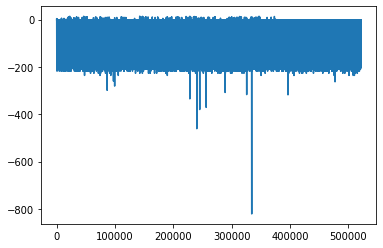

In [31]:
import matplotlib.pyplot as plt
plt.plot(scores)